In [ ]:
import av  
import cv2
import mediapipe as mp
import pandas as pd
import csv
import numpy as np
import matplotlib.pyplot as plt

In [1]:
mp_hands = mp.solutions.hands
mp_draw = mp.solutions.drawing_utils
hands = mp_hands.Hands(static_image_mode=False, max_num_hands=2)

container = av.open("2025-07-02 14-29-36.mp4")
stream = container.streams.video[0]
fps = float(stream.average_rate) if stream.average_rate else 30  
print(f"Detected FPS from PyAV: {fps}")

width = stream.codec_context.width
height = stream.codec_context.height
fourcc = cv2.VideoWriter_fourcc(*'avc1')
out = cv2.VideoWriter("2025-07-02 14-29-36_overlay.mov", fourcc, fps, (width, height))

landmark_csv = open("hand_landmarks_05-2.csv", mode="w", newline="")
landmark_writer = csv.writer(landmark_csv)
landmark_writer.writerow(["frame", "time_sec", "hand", "landmark_id", "x", "y", "z", "hand_detected"])

summary_csv = open("frame_detection_summary.csv", mode="w", newline="")
summary_writer = csv.writer(summary_csv)
summary_writer.writerow(["frame", "time_sec", "hands_detected", "hand_labels_detected"])

frame_num = 0
frames_with_detection = 0
total_frames = 0

for frame in container.decode(video=0):
    # PyAV frame -> numpy array (RGB)
    img = frame.to_ndarray(format="bgr24")
    time_sec = float(frame.pts * frame.time_base) if frame.pts else frame_num / fps

    img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    result = hands.process(img_rgb)

    detected_labels = []

    if result.multi_hand_landmarks and result.multi_handedness:
        hands_detected = len(result.multi_hand_landmarks)
        frames_with_detection += 1

        for (hand_landmarks, handedness) in zip(result.multi_hand_landmarks, result.multi_handedness):
            hand_label = handedness.classification[0].label  # 'Left' or 'Right'
            detected_labels.append(hand_label)

            for idx, lm in enumerate(hand_landmarks.landmark):
                landmark_writer.writerow([frame_num, time_sec, hand_label, idx, lm.x, lm.y, lm.z, 1])

            # Draw with different color
            color = (0, 255, 0) if hand_label == "Left" else (0, 0, 255)
            mp_draw.draw_landmarks(
                img, hand_landmarks, mp_hands.HAND_CONNECTIONS,
                mp_draw.DrawingSpec(color=color, thickness=2, circle_radius=3),
                mp_draw.DrawingSpec(color=color, thickness=2)
            )
    else:
        hands_detected = 0
        for hand_label in ['Left', 'Right']:
            for idx in range(21):
                landmark_writer.writerow([frame_num, time_sec, hand_label, idx, None, None, None, 0])

    summary_writer.writerow([frame_num, time_sec, hands_detected, ','.join(detected_labels)])

    out.write(img)

    cv2.imshow("Hand Detection VFR", img)
    if cv2.waitKey(1) & 0xFF == ord('q'):
        break

    frame_num += 1
    total_frames += 1

landmark_csv.close()
summary_csv.close()
out.release()
cv2.destroyAllWindows()

print("-------- Detection Report --------")
print(f"Total frames: {total_frames}")
print(f"Frames with at least 1 hand detected: {frames_with_detection}")
print(f"Detection rate: {frames_with_detection/total_frames:.2%}")

I0000 00:00:1752197952.668486 23346697 gl_context.cc:369] GL version: 2.1 (2.1 Metal - 89.4), renderer: Apple M3 Pro
INFO: Created TensorFlow Lite XNNPACK delegate for CPU.
W0000 00:00:1752197952.675799 23347754 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1752197952.681437 23347757 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.


Detected FPS from PyAV: 60.0


W0000 00:00:1752197957.329008 23347752 landmark_projection_calculator.cc:186] Using NORM_RECT without IMAGE_DIMENSIONS is only supported for the square ROI. Provide IMAGE_DIMENSIONS or use PROJECTION_MATRIX.


-------- Detection Report --------
Total frames: 5267
Frames with at least 1 hand detected: 4314
Detection rate: 81.91%


In [2]:
df = pd.read_csv("hand_landmarks_05-2.csv")

print("Shape:", df.shape)
df

Shape: (136668, 8)


,frame,time_sec,hand,landmark_id,x,y,z,hand_detected
0,0,0.0,Right,0,0.358288,0.721980,8.159707e-07,1
1,0,0.0,Right,1,0.384820,0.721488,-5.477338e-02,1
2,0,0.0,Right,2,0.405222,0.696499,-8.894239e-02,1
3,0,0.0,Right,3,0.428845,0.672177,-1.135368e-01,1
4,0,0.0,Right,4,0.445392,0.668945,-1.376140e-01,1
...,...,...,...,...,...,...,...,...
136663,5266,87.8,Right,16,NaN,NaN,NaN,0
136664,5266,87.8,Right,17,NaN,NaN,NaN,0
136665,5266,87.8,Right,18,NaN,NaN,NaN,0
136666,5266,87.8,Right,19,NaN,NaN,NaN,0


In [3]:
df_wide = df.pivot_table(index=["frame", "time_sec", "hand", "hand_detected"], 
                                columns="landmark_id", 
                                values=["x", "y", "z"])
df_wide.columns = [f"{coord}_{lmk}" for coord, lmk in df_wide.columns]
df_wide = df_wide.reset_index()

df_wide

,frame,time_sec,hand,hand_detected,x_0,x_1,x_2,x_3,x_4,x_5,...,z_11,z_12,z_13,z_14,z_15,z_16,z_17,z_18,z_19,z_20
0,0,0.000000,Right,1,0.358288,0.384820,0.405222,0.428845,0.445392,0.382385,...,-0.053063,-0.056960,-0.015220,-0.023310,-0.028986,-0.032879,-0.000983,-0.005208,-0.009194,-0.012525
1,1,0.016667,Right,1,0.347916,0.372539,0.396373,0.422310,0.437586,0.368912,...,-0.031244,-0.034223,0.003595,0.002650,-0.003352,-0.007831,0.025097,0.026963,0.024142,0.021464
2,2,0.033333,Right,1,0.338434,0.369971,0.398001,0.424900,0.437965,0.366754,...,-0.011064,-0.012759,0.014832,0.018906,0.014168,0.010474,0.035047,0.040898,0.039676,0.038167
3,3,0.050000,Right,1,0.337050,0.371995,0.400735,0.425738,0.437209,0.366591,...,-0.008867,-0.009990,0.014858,0.018603,0.013436,0.009921,0.033999,0.039500,0.037724,0.036186
4,4,0.066667,Right,1,0.334394,0.366327,0.392069,0.415638,0.423478,0.359246,...,0.008591,0.008864,0.022661,0.029960,0.028724,0.027536,0.039873,0.047824,0.049360,0.050106
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4507,5034,83.900000,Right,1,0.375941,0.411525,0.425494,0.430249,0.432390,0.348710,...,-0.069405,-0.066135,-0.033153,-0.051404,-0.043811,-0.036654,-0.015912,-0.033451,-0.033489,-0.030323
4508,5035,83.916667,Right,1,0.420122,0.440159,0.451704,0.458601,0.459360,0.369005,...,-0.078420,-0.074574,-0.047063,-0.066615,-0.061266,-0.054722,-0.036394,-0.053344,-0.052922,-0.048994
4509,5036,83.933333,Right,1,0.415064,0.444230,0.458953,0.465562,0.467191,0.371996,...,-0.065029,-0.063396,-0.034510,-0.050421,-0.044404,-0.038393,-0.024875,-0.038768,-0.037634,-0.033446
4510,5037,83.950000,Right,1,0.431701,0.460092,0.486932,0.513023,0.530860,0.428801,...,-0.086711,-0.084646,-0.057818,-0.076094,-0.069448,-0.062858,-0.053191,-0.064603,-0.059934,-0.054537


In [4]:
df_wide['time_sec'] = df_wide['time_sec'].round(3)

df_wide

,frame,time_sec,hand,hand_detected,x_0,x_1,x_2,x_3,x_4,x_5,...,z_11,z_12,z_13,z_14,z_15,z_16,z_17,z_18,z_19,z_20
0,0,0.000,Right,1,0.358288,0.384820,0.405222,0.428845,0.445392,0.382385,...,-0.053063,-0.056960,-0.015220,-0.023310,-0.028986,-0.032879,-0.000983,-0.005208,-0.009194,-0.012525
1,1,0.017,Right,1,0.347916,0.372539,0.396373,0.422310,0.437586,0.368912,...,-0.031244,-0.034223,0.003595,0.002650,-0.003352,-0.007831,0.025097,0.026963,0.024142,0.021464
2,2,0.033,Right,1,0.338434,0.369971,0.398001,0.424900,0.437965,0.366754,...,-0.011064,-0.012759,0.014832,0.018906,0.014168,0.010474,0.035047,0.040898,0.039676,0.038167
3,3,0.050,Right,1,0.337050,0.371995,0.400735,0.425738,0.437209,0.366591,...,-0.008867,-0.009990,0.014858,0.018603,0.013436,0.009921,0.033999,0.039500,0.037724,0.036186
4,4,0.067,Right,1,0.334394,0.366327,0.392069,0.415638,0.423478,0.359246,...,0.008591,0.008864,0.022661,0.029960,0.028724,0.027536,0.039873,0.047824,0.049360,0.050106
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4507,5034,83.900,Right,1,0.375941,0.411525,0.425494,0.430249,0.432390,0.348710,...,-0.069405,-0.066135,-0.033153,-0.051404,-0.043811,-0.036654,-0.015912,-0.033451,-0.033489,-0.030323
4508,5035,83.917,Right,1,0.420122,0.440159,0.451704,0.458601,0.459360,0.369005,...,-0.078420,-0.074574,-0.047063,-0.066615,-0.061266,-0.054722,-0.036394,-0.053344,-0.052922,-0.048994
4509,5036,83.933,Right,1,0.415064,0.444230,0.458953,0.465562,0.467191,0.371996,...,-0.065029,-0.063396,-0.034510,-0.050421,-0.044404,-0.038393,-0.024875,-0.038768,-0.037634,-0.033446
4510,5037,83.950,Right,1,0.431701,0.460092,0.486932,0.513023,0.530860,0.428801,...,-0.086711,-0.084646,-0.057818,-0.076094,-0.069448,-0.062858,-0.053191,-0.064603,-0.059934,-0.054537


In [5]:
df2 = pd.read_csv("hand_lable_05-2.csv")

print("Shape:", df.shape)
df2

Shape: (136668, 8)


,Observation id,Observation date,Description,Observation duration,Observation type,Source,Time offset (s),Media duration (s),FPS,Subject,Behavior,Behavioral category,Behavior type,Time,Media file name,Image index,Image file path,Comment
0,05-2,2025-07-08 22:54:39.369,NaN,66.634,Media file(s),player #1:D:/Data Science/UOB/DS_project/Full ...,0.0,87.783,60.0,NaN,other,NaN,START,10.883,D:/Data Science/UOB/DS_project/Full Study/05-2...,653,NaN,NaN
1,05-2,2025-07-08 22:54:39.369,NaN,66.634,Media file(s),player #1:D:/Data Science/UOB/DS_project/Full ...,0.0,87.783,60.0,NaN,other,NaN,STOP,11.400,D:/Data Science/UOB/DS_project/Full Study/05-2...,684,NaN,NaN
2,05-2,2025-07-08 22:54:39.369,NaN,66.634,Media file(s),player #1:D:/Data Science/UOB/DS_project/Full ...,0.0,87.783,60.0,NaN,lift,NaN,START,11.417,D:/Data Science/UOB/DS_project/Full Study/05-2...,685,NaN,NaN
3,05-2,2025-07-08 22:54:39.369,NaN,66.634,Media file(s),player #1:D:/Data Science/UOB/DS_project/Full ...,0.0,87.783,60.0,NaN,lift,NaN,STOP,12.667,D:/Data Science/UOB/DS_project/Full Study/05-2...,760,NaN,NaN
4,05-2,2025-07-08 22:54:39.369,NaN,66.634,Media file(s),player #1:D:/Data Science/UOB/DS_project/Full ...,0.0,87.783,60.0,NaN,hold,NaN,START,12.683,D:/Data Science/UOB/DS_project/Full Study/05-2...,761,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
87,05-2,2025-07-08 22:54:39.369,NaN,66.634,Media file(s),player #1:D:/Data Science/UOB/DS_project/Full ...,0.0,87.783,60.0,NaN,hold,NaN,STOP,76.467,D:/Data Science/UOB/DS_project/Full Study/05-2...,4588,NaN,NaN
88,05-2,2025-07-08 22:54:39.369,NaN,66.634,Media file(s),player #1:D:/Data Science/UOB/DS_project/Full ...,0.0,87.783,60.0,NaN,adjust,NaN,START,76.483,D:/Data Science/UOB/DS_project/Full Study/05-2...,4589,NaN,NaN
89,05-2,2025-07-08 22:54:39.369,NaN,66.634,Media file(s),player #1:D:/Data Science/UOB/DS_project/Full ...,0.0,87.783,60.0,NaN,adjust,NaN,STOP,76.833,D:/Data Science/UOB/DS_project/Full Study/05-2...,4610,NaN,NaN
90,05-2,2025-07-08 22:54:39.369,NaN,66.634,Media file(s),player #1:D:/Data Science/UOB/DS_project/Full ...,0.0,87.783,60.0,NaN,hold,NaN,START,76.850,D:/Data Science/UOB/DS_project/Full Study/05-2...,4611,NaN,NaN


In [6]:
df_sub = df2[['Behavior', 'Behavior type', 'Time', 'Image index']]

df_start = df_sub[df_sub['Behavior type'] == 'START'].copy()
df_stop  = df_sub[df_sub['Behavior type'] == 'STOP'].copy()

df_start = df_start.reset_index(drop=True)
df_stop  = df_stop.reset_index(drop=True)

df_events = pd.DataFrame({
    'behavior': df_start['Behavior'],
    'start_time': df_start['Time'],
    'stop_time': df_stop['Time'],
    'start_image_index': df_start['Image index'],
    'stop_image_index': df_stop['Image index']
})

df_events

,behavior,start_time,stop_time,start_image_index,stop_image_index
0,other,10.883,11.400,653,684
1,lift,11.417,12.667,685,760
2,hold,12.683,13.717,761,823
3,press,13.733,14.200,824,852
4,hold,14.217,14.517,853,871
5,press,14.533,14.733,872,884
6,hold,14.750,15.100,885,906
7,press,15.117,15.317,907,919
8,hold,15.333,15.600,920,936
9,adjust,15.617,17.517,937,1051


In [7]:
df_wide['behavior'] = np.nan

for _, row in df_events.iterrows():
    b = row['behavior']
    t_start = row['start_time']
    t_stop = row['stop_time']

    mask = (df_wide['time_sec'] >= t_start) & (df_wide['time_sec'] <= t_stop)

    df_wide.loc[mask, 'behavior'] = b

df_wide

/var/folders/rj/522y7b7n1dl67qg86lzg9y_00000gn/T/ipykernel_21684/1143471531.py:14: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value 'other' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  df_wide.loc[mask, 'behavior'] = b


,frame,time_sec,hand,hand_detected,x_0,x_1,x_2,x_3,x_4,x_5,...,z_12,z_13,z_14,z_15,z_16,z_17,z_18,z_19,z_20,behavior
0,0,0.000,Right,1,0.358288,0.384820,0.405222,0.428845,0.445392,0.382385,...,-0.056960,-0.015220,-0.023310,-0.028986,-0.032879,-0.000983,-0.005208,-0.009194,-0.012525,NaN
1,1,0.017,Right,1,0.347916,0.372539,0.396373,0.422310,0.437586,0.368912,...,-0.034223,0.003595,0.002650,-0.003352,-0.007831,0.025097,0.026963,0.024142,0.021464,NaN
2,2,0.033,Right,1,0.338434,0.369971,0.398001,0.424900,0.437965,0.366754,...,-0.012759,0.014832,0.018906,0.014168,0.010474,0.035047,0.040898,0.039676,0.038167,NaN
3,3,0.050,Right,1,0.337050,0.371995,0.400735,0.425738,0.437209,0.366591,...,-0.009990,0.014858,0.018603,0.013436,0.009921,0.033999,0.039500,0.037724,0.036186,NaN
4,4,0.067,Right,1,0.334394,0.366327,0.392069,0.415638,0.423478,0.359246,...,0.008864,0.022661,0.029960,0.028724,0.027536,0.039873,0.047824,0.049360,0.050106,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4507,5034,83.900,Right,1,0.375941,0.411525,0.425494,0.430249,0.432390,0.348710,...,-0.066135,-0.033153,-0.051404,-0.043811,-0.036654,-0.015912,-0.033451,-0.033489,-0.030323,NaN
4508,5035,83.917,Right,1,0.420122,0.440159,0.451704,0.458601,0.459360,0.369005,...,-0.074574,-0.047063,-0.066615,-0.061266,-0.054722,-0.036394,-0.053344,-0.052922,-0.048994,NaN
4509,5036,83.933,Right,1,0.415064,0.444230,0.458953,0.465562,0.467191,0.371996,...,-0.063396,-0.034510,-0.050421,-0.044404,-0.038393,-0.024875,-0.038768,-0.037634,-0.033446,NaN
4510,5037,83.950,Right,1,0.431701,0.460092,0.486932,0.513023,0.530860,0.428801,...,-0.084646,-0.057818,-0.076094,-0.069448,-0.062858,-0.053191,-0.064603,-0.059934,-0.054537,NaN


In [8]:
print(df_wide['behavior'].value_counts(dropna=False))

behavior
press     1608
NaN        978
rotate     937
adjust     540
hold       229
lift       110
other       57
place       53
Name: count, dtype: int64


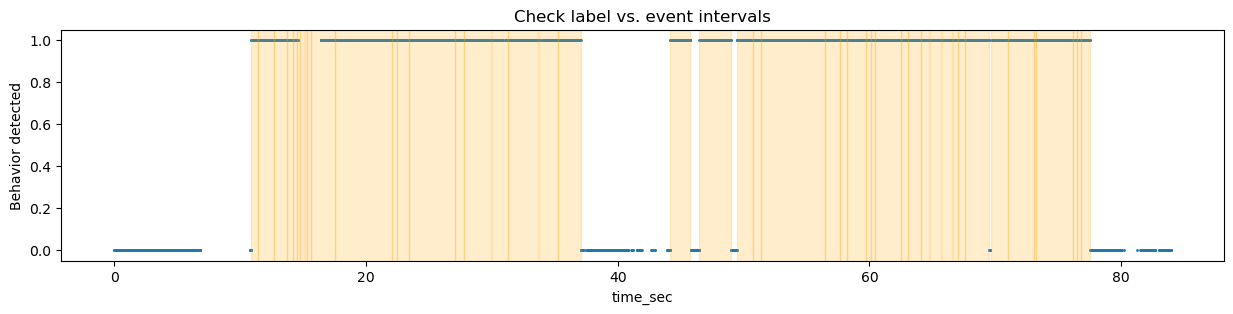

In [9]:
plt.figure(figsize=(15, 3))
plt.scatter(df_wide['time_sec'], df_wide['behavior'].notna(), s=1)
for _, row in df_events.iterrows():
    plt.axvspan(row['start_time'], row['stop_time'], color='orange', alpha=0.2)

plt.xlabel("time_sec")
plt.ylabel("Behavior detected")
plt.title("Check label vs. event intervals")
plt.show()

In [10]:
df_clean = df_wide.dropna(subset=['behavior'])

df_wide = df_clean

df_wide

,frame,time_sec,hand,hand_detected,x_0,x_1,x_2,x_3,x_4,x_5,...,z_12,z_13,z_14,z_15,z_16,z_17,z_18,z_19,z_20,behavior
418,653,10.883,Right,1,0.315347,0.342697,0.365720,0.385300,0.398116,0.289202,...,-0.040630,0.002172,-0.011019,-0.019101,-0.022574,0.016785,0.003436,-0.004291,-0.007118,other
419,654,10.900,Right,1,0.296827,0.336194,0.358881,0.380886,0.401974,0.287398,...,-0.005637,0.029915,0.034446,0.023894,0.015317,0.052868,0.054231,0.047619,0.043309,other
420,655,10.917,Right,1,0.282525,0.330051,0.356119,0.382847,0.407974,0.287459,...,0.005331,0.036106,0.041862,0.033594,0.027700,0.060975,0.063398,0.057673,0.054868,other
421,656,10.933,Right,1,0.284882,0.331758,0.357601,0.385134,0.409078,0.289613,...,-0.000651,0.028825,0.033286,0.026614,0.021721,0.055251,0.056534,0.050761,0.047966,other
422,657,10.950,Right,1,0.281764,0.335045,0.366646,0.396201,0.424446,0.300926,...,0.038986,0.045432,0.059509,0.057113,0.054092,0.070189,0.079110,0.076103,0.074388,other
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4253,4647,77.450,Right,1,0.465910,0.450674,0.470753,0.522991,0.573972,0.516922,...,-0.049203,0.015384,-0.023020,-0.037083,-0.033790,0.011224,-0.017644,-0.024936,-0.021603,hold
4254,4648,77.467,Right,1,0.463657,0.450867,0.470805,0.522135,0.572813,0.510151,...,-0.048295,0.017686,-0.017960,-0.032152,-0.029965,0.014515,-0.010402,-0.017014,-0.014191,hold
4255,4649,77.483,Right,1,0.465040,0.451495,0.471163,0.521727,0.570894,0.510737,...,-0.049081,0.023932,-0.011944,-0.030807,-0.031480,0.024183,-0.000826,-0.009796,-0.008555,hold
4256,4650,77.500,Right,1,0.458748,0.450214,0.471038,0.521015,0.569844,0.507878,...,-0.049634,0.020794,-0.012518,-0.029901,-0.030289,0.021517,0.000096,-0.007751,-0.006396,hold


In [11]:
df_wide['dataset_id'] = '0502'

cols = df_wide.columns.tolist()
cols = ['dataset_id'] + [col for col in cols if col != 'dataset_id']
df_wide = df_wide[cols]

df_wide

/var/folders/rj/522y7b7n1dl67qg86lzg9y_00000gn/T/ipykernel_21684/4188080076.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_wide['dataset_id'] = '0502'


,dataset_id,frame,time_sec,hand,hand_detected,x_0,x_1,x_2,x_3,x_4,...,z_12,z_13,z_14,z_15,z_16,z_17,z_18,z_19,z_20,behavior
418,0502,653,10.883,Right,1,0.315347,0.342697,0.365720,0.385300,0.398116,...,-0.040630,0.002172,-0.011019,-0.019101,-0.022574,0.016785,0.003436,-0.004291,-0.007118,other
419,0502,654,10.900,Right,1,0.296827,0.336194,0.358881,0.380886,0.401974,...,-0.005637,0.029915,0.034446,0.023894,0.015317,0.052868,0.054231,0.047619,0.043309,other
420,0502,655,10.917,Right,1,0.282525,0.330051,0.356119,0.382847,0.407974,...,0.005331,0.036106,0.041862,0.033594,0.027700,0.060975,0.063398,0.057673,0.054868,other
421,0502,656,10.933,Right,1,0.284882,0.331758,0.357601,0.385134,0.409078,...,-0.000651,0.028825,0.033286,0.026614,0.021721,0.055251,0.056534,0.050761,0.047966,other
422,0502,657,10.950,Right,1,0.281764,0.335045,0.366646,0.396201,0.424446,...,0.038986,0.045432,0.059509,0.057113,0.054092,0.070189,0.079110,0.076103,0.074388,other
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4253,0502,4647,77.450,Right,1,0.465910,0.450674,0.470753,0.522991,0.573972,...,-0.049203,0.015384,-0.023020,-0.037083,-0.033790,0.011224,-0.017644,-0.024936,-0.021603,hold
4254,0502,4648,77.467,Right,1,0.463657,0.450867,0.470805,0.522135,0.572813,...,-0.048295,0.017686,-0.017960,-0.032152,-0.029965,0.014515,-0.010402,-0.017014,-0.014191,hold
4255,0502,4649,77.483,Right,1,0.465040,0.451495,0.471163,0.521727,0.570894,...,-0.049081,0.023932,-0.011944,-0.030807,-0.031480,0.024183,-0.000826,-0.009796,-0.008555,hold
4256,0502,4650,77.500,Right,1,0.458748,0.450214,0.471038,0.521015,0.569844,...,-0.049634,0.020794,-0.012518,-0.029901,-0.030289,0.021517,0.000096,-0.007751,-0.006396,hold


In [37]:
df_wide.to_csv("handlandmark_wide_05-2.csv", index=False)